# Libraries

In [1]:
#Load all important libraries
import http.client
import json
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
from openai import OpenAI
import re
import spacy
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
import math

# Data Loading

In [2]:
# Generating some example data
week = 46
month = 11
monat = 'November'
HotelName = 'Aparthotel Adagio Frankfurt City Messe'
City = 'Frankfurt'
Street = 'Hamburger Allee 4 '
id = 1758394 # this is hotel_id

In [3]:
#Load the Data_Frames: General, Placeholder, Neg, Pos
df_gen = pd.read_excel('../'+str(id)+"/General "+str(id)+".xlsx")
df_neg = pd.read_excel('../'+str(id)+"/Neg "+str(id)+".xlsx")
df_pos = pd.read_excel('../'+str(id)+"/Pos "+str(id)+".xlsx")
df_placeholder = pd.read_excel('../'+str(id)+'/Week_'+str(week)+'/placeholder_week_'+str(week)+'_id_'+str(id)+'.xlsx')

# Process Data only October and November

In [4]:
# Take only Cells from November Comments
df_gen['Woche'] = df_gen['Comment_Date'].dt.isocalendar().week
df_gen['Month'] = df_gen['Comment_Date'].dt.month

In [5]:
# November 46CW and 45CW: Weekly Highlights
df_sub_46_gen=df_gen[(df_gen['Woche']==week)].copy() #<-----46CW Weekly Highlights
df_sub_45_gen=df_gen[(df_gen['Woche']==week-1)].copy() #<-----45CW Weekly Highlights

In [6]:
# Take only Cells from 46CW Positive Comments
df_pos['Woche'] = df_pos['Date'].dt.isocalendar().week
df_pos['Month'] = df_pos['Date'].dt.month
# November 46KW: Weekly Highlights Positive Comments
df_sub_46_pos=df_pos[(df_pos['Woche']==week)].copy() #<----- Weekly Highlights
df_sub_45_pos=df_pos[(df_pos['Woche']==week-1)].copy() #<----- Weekly Highlights

In [7]:
# Take only Cells from 46CW Negative Comments
df_neg['Woche'] = df_neg['Date'].dt.isocalendar().week
df_neg['Month'] = df_neg['Date'].dt.month
# November 45KW: Weekly Highlights Negative Comments
df_sub_46_neg=df_neg[(df_neg['Woche']==week)].copy() #<----- Weekly Highlights
df_sub_45_neg=df_neg[(df_neg['Woche']==week-1)].copy() #<----- Weekly Highlights

# Weekly Highlights

## Data Overview

### Score for November Week 46

In [1]:
# Data Overview for Week 46
df_sub_46_gen["Score"].describe()
df_sub_46_gen['Score'].value_counts()
counts = df_sub_46_gen['Score'].value_counts().sum()

NameError: name 'df_sub_46_gen' is not defined

In [11]:
# Safe the important values
# they will be later saved in placeholder.xlsx
score_min=df_sub_46_gen["Score"].describe()['min']
score_max=df_sub_46_gen["Score"].describe()['max']
score_mean=df_sub_46_gen["Score"].describe()['mean']
score_q1=df_sub_46_gen["Score"].describe()['25%']
score_q2=df_sub_46_gen["Score"].describe()['75%']

In [12]:
# Create a text for describing the statistics
score_text = 'Score-Distribution:\nThe boxplot shows the distribution of scores. The lowest rating given was a ' + str(round(score_min)) + ', the highest rating given was a ' + str(round(score_max)) + '. The average rating is ' + str(round(score_mean, 2)) + ', and 50% of guests rated the hotel between ' + str(round(score_q1, 2)) + ' and ' + str(round(score_q2, 2)) + '.'

In [13]:
# safe the values in placeholder dataframe
df_placeholder.loc[df_placeholder["Placeholder"]=='{{Score_Week}}','Content']=score_text

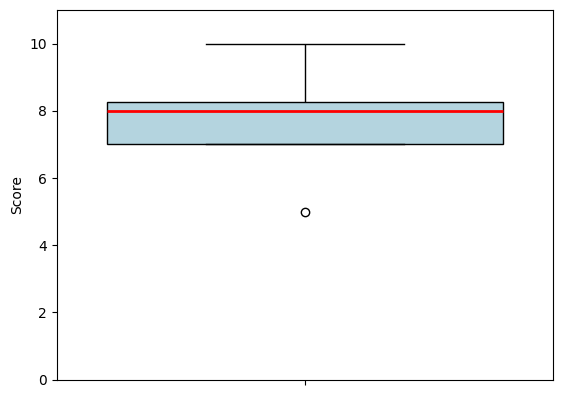

In [14]:
# Create a box plot
sns.boxplot(y='Score', data=df_sub_46_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

# Add labels and title
plt.ylabel('Score')
plt.ylim(0,11)

plt.savefig('../'+str(id)+"/Week_"+str(week)+"/score.png",bbox_inches='tight')
# Show plot
plt.show()


In [15]:
# Generate an explanation text for the boxplot
score_levels=[0]
text=''
j=0
for i in range(1,11):
    score_levels.append(df_sub_46_gen["Score"].value_counts().get(i,0))
    if score_levels[i] > 1:
        text = text +'The score level '+str(i)+' has '+str(score_levels[i])+' ratings ('+str(round(100*score_levels[i]/counts,1))+'%). '
    elif score_levels[i] == 1:
        text = text +'The score level '+str(i)+' has one rating ('+str(round(100*score_levels[i]/counts,1))+'%). '
    else:
        j=1
if j==1:
    text = text + 'No ratings were given for the other score levels.'
sum(score_levels)  
score_level_text = 'Score-Level Distribution:\nThe bar plot shows the score values for each score level. A total of ' + str(sum(score_levels)) + ' ratings were given. ' + text
# save the values in Placeholder DataFrame
df_placeholder.loc[df_placeholder["Placeholder"]=='{{Score_Level_Week}}','Content']=score_level_text

8

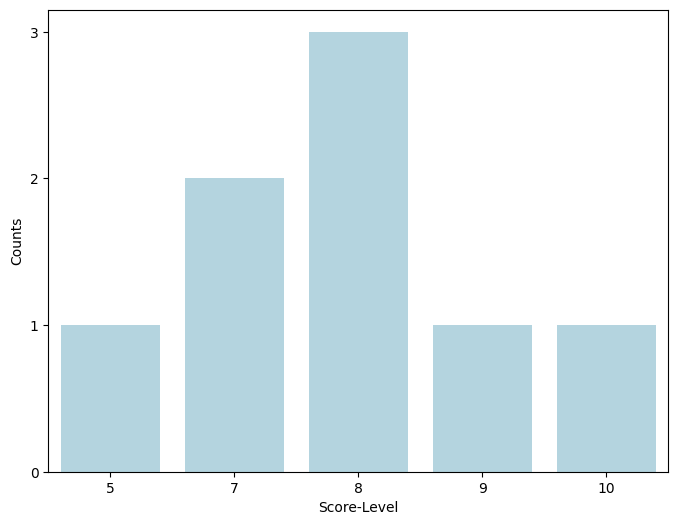

In [19]:
# Create a Barplot
plt.figure(figsize=(8, 6))  # size of the diagram
sns.barplot(df_sub_46_gen["Score"].value_counts(), color='lightblue', legend=False)

# add labels
plt.xlabel('Score-Level')
plt.ylabel('Counts')
# only wholenumbers on y-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/score_level.png",bbox_inches='tight')
# show plot
plt.show()


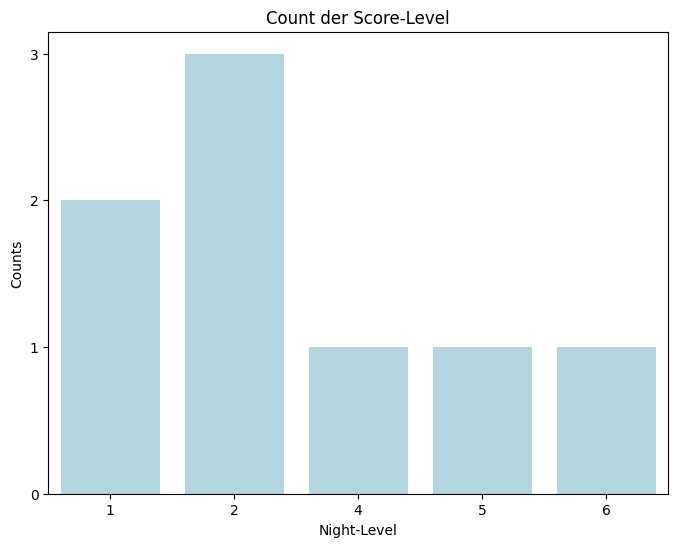

In [20]:
# Create barplot
plt.figure(figsize=(8, 6)) 
sns.barplot(df_sub_46_gen["Nights"].value_counts(), color='lightblue', legend=False)

# add labels
plt.title('Count der Score-Level')
plt.xlabel('Night-Level')
plt.ylabel('Counts')
# only wholenumbers in y-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/Nacht Week.png")
# show plot
plt.show()

### Customer Type Distribution

In [21]:
df_sub_46_gen["Customer_Type"].describe()

count                  8
unique                 3
top       Solo traveller
freq                   4
Name: Customer_Type, dtype: object

In [22]:
df_sub_46_gen["Customer_Type"].value_counts()

Customer_Type
Solo traveller      4
Group of friends    2
Couple              2
Name: count, dtype: int64

In [23]:
# define values for the text
customer_count = df_sub_46_gen['Customer_Type'].value_counts().sum()
customer_typen = df_sub_46_gen["Customer_Type"].value_counts().index.tolist()

In [24]:
# create the dynamic text for describing the graph
customer_types=[0]
customer_text1=''
j=0
for i in df_sub_45_gen["Customer_Type"].value_counts().index.tolist():
    k=df_sub_45_gen["Customer_Type"].value_counts().get(i,0)
    customer_types.append(k)
    if k > 1:
        customer_text1 = customer_text1 +'The customer type '+i+' has '+str(k)+' ratings ('+str(round((k/customer_count)*100,1))+'%). '
    elif k == 1:
        customer_text1 = customer_text1 +'The customer type '+i+' has one rating ('+str(round(100/customer_count,1))+'%). '
    else:
        j=1
if j==1:
    customer_text1 = customer_text1 + 'No ratings were given for the other customer types.'
sum(customer_types)  

6

In [25]:
# create text for the Placeholder
customer_text = 'Customer Type Distribution:\nThe pie chart shows the proportions of different customer types. The ' + str(customer_count) + ' guest ratings are divided into the following customer types: ' + str(', '.join(customer_typen)) + '. ' + customer_text1

In [26]:
# save the Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Customer_Week}}','Content']=customer_text

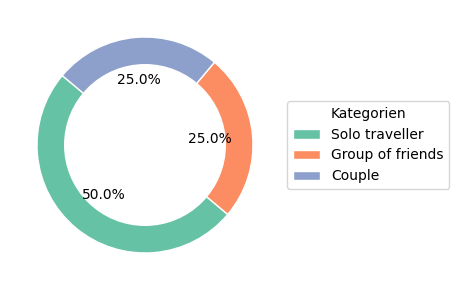

In [27]:
# Seaborn-colorpalette
colors = sns.color_palette("Set2", len(df_sub_46_gen["Customer_Type"].value_counts()))  # 'Set2' Palette

# create a pie diagram
plt.figure(figsize=(8, 3))
plt.pie(df_sub_46_gen["Customer_Type"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)

# add legend 
plt.legend(df_sub_46_gen["Customer_Type"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/customer.png",bbox_inches='tight')
# show plot
plt.show()


### Number of Comment Distribution

In [30]:
# overview and safe a text for describing the data
positiv_counts = df_sub_46_gen["Positiv"].describe()['count']
negativ_counts = df_sub_46_gen["Negativ"].describe()['count']
pos_neg_sum = positiv_counts+negativ_counts
pos_neg_text = 'Positive-Negative Distribution:\nThis week, there were ' + str(positiv_counts) + ' positive (' + str(round(100 * positiv_counts / pos_neg_sum, 1)) + '%) and ' + str(negativ_counts) + ' negative (' + str(round(100 * negativ_counts / pos_neg_sum, 1)) + '%) comments, with a customer being able to write both positive and negative feedback.'
df_placeholder.loc[df_placeholder['Placeholder']=='{{Pos_Neg}}',['Content']]=pos_neg_text
pos_neg_text

'Positive-Negative Distribution:\nThis week, there were 4 positive (50.0%) and 4 negative (50.0%) comments, with a customer being able to write both positive and negative feedback.'

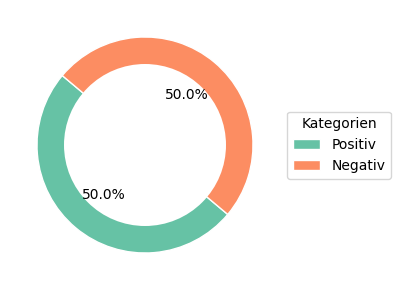

In [31]:
# visualize the data
pos_neg_size = [df_sub_46_gen["Positiv"].describe()["count"],df_sub_46_gen["Negativ"].describe()["count"]]
pos_neg_label = ["Positiv","Negativ"]
# color-palaette
colors = sns.color_palette("Set2", len(pos_neg_size))  # 'Set2' Palette

# create pie-diagram
plt.figure(figsize=(8, 3))
plt.pie(pos_neg_size, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)

# add legend
plt.legend(pos_neg_label, loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/pos_neg.png",bbox_inches='tight')
# show plot
plt.show()


### Romm Category Distribution

In [32]:
df_sub_46_gen["Room_Name"].describe()
df_sub_46_gen["Room_Name"].value_counts()

count                     8
unique                    2
top       Studio (2 Adults)
freq                      6
Name: Room_Name, dtype: object

In [34]:
# define the values
room_count = df_sub_46_gen['Room_Name'].value_counts().sum()
room_typen = df_sub_46_gen['Room_Name'].value_counts().index.tolist()
# create the text for the graph
room_tpyes=[0]
room_text1=''
j=0
for i in df_sub_46_gen['Room_Name'].value_counts().index.tolist():
    k=df_sub_46_gen['Room_Name'].value_counts().get(i,0)
    room_tpyes.append(k)
    if k > 1:
        room_text1 = room_text1 +'The room type '+i+' has '+str(k)+' ratings ('+str(round((k/room_count)*100,1))+'%). '
    elif k == 1:
        room_text1 = room_text1 +'The room type '+i+' has one rating ('+str(round(100/room_count,1))+'%). '
    else:
        j=1
if j==1:
    room_text1 = room_text1 + 'No rating were given for the other room types.'
sum(room_tpyes)
# create the text
room_text = 'Room Class Distribution:\nThe pie chart shows the proportions of different room classes. This week, guests have rated the following room classes: ' + str(', '.join(room_typen)) + '. ' + room_text1
# save the Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Room_Week}}','Content']=room_text

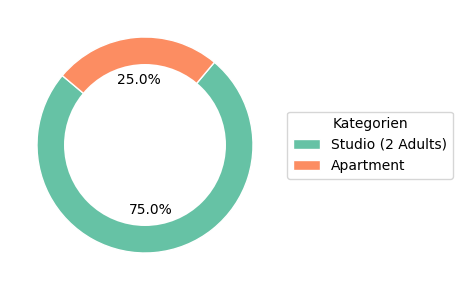

In [35]:
# use Seaborn-Farbpalette
colors = sns.color_palette("Set2", len(df_sub_46_gen["Room_Name"].value_counts()))  # 'Set2' Palette

# create pie chart
plt.figure(figsize=(8, 3))
plt.pie(df_sub_46_gen["Room_Name"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)

# add legend
plt.legend(df_sub_46_gen["Room_Name"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/room.png",bbox_inches='tight')
# show plot
plt.show()


### Travel Purpose Distribution

In [36]:
df_sub_46_gen["Travel_Purpose"].describe()
df_sub_46_gen["Travel_Purpose"].value_counts()

count            8
unique           2
top       business
freq             5
Name: Travel_Purpose, dtype: object

In [38]:
# define the values
travel_count = df_sub_46_gen['Travel_Purpose'].value_counts().sum()
travel_typen = df_sub_46_gen['Travel_Purpose'].value_counts().index.tolist()
# create the dynamic text for graph explanation
travel_types=[0]
travel_text1=''
j=0
for i in df_sub_46_gen['Travel_Purpose'].value_counts().index.tolist():
    k=df_sub_46_gen['Travel_Purpose'].value_counts().get(i,0)
    travel_types.append(k)
    if k > 1:
        travel_text1 = travel_text1 +'The travel purpose '+i+' has '+str(k)+' ('+str(round((k/travel_count)*100,1))+'%) ratings. '
    elif k == 1:
        travel_text1 = travel_text1 +'The travel purpose '+i+' has one rating ('+str(round(100/travel_count,1))+'%). '
    else:
        j=1
if j==1:
    travel_text1 = travel_text1 + 'No other ratings were given to the other travel purposes.'
sum(travel_types)
# create Text for Placeholder
travel_text = 'Travel Purpose Distribution:\nThe pie chart shows the proportions of different travel purposes. Guests traveled for the following reasons: ' + str(', '.join(travel_typen)) + '. ' + travel_text1
# save in  Placeholder DataFrame
df_placeholder.loc[df_placeholder['Placeholder']=='{{Travel_Week}}','Content']=travel_text

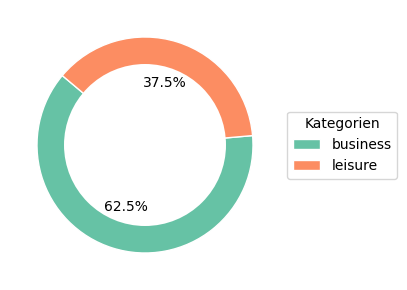

In [39]:
# use seaborn palette
colors = sns.color_palette("Set2", len(df_sub_46_gen["Travel_Purpose"].value_counts()))  # 'Set2' Palette

# create pie chart
plt.figure(figsize=(8, 3))
plt.pie(df_sub_46_gen["Travel_Purpose"].value_counts(), autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'white'})
hole = plt.Circle((0, 0), 0.75, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.legend(df_sub_46_gen["Travel_Purpose"].value_counts().index.tolist(), loc="center left", bbox_to_anchor=(1, 0.5), title="Kategorien")
plt.tight_layout()
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/travel.png",bbox_inches='tight')

plt.show()


## Score Highlights

### Score x Room Category

In [40]:
df_sub_46_gen.groupby("Room_Name")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Room_Name,,,,,,,,
Apartment,2.0,6.000000,1.414214,5.0,5.5,6.0,6.50,7.0
Studio (2 Adults),6.0,8.333333,1.032796,7.0,8.0,8.0,8.75,10.0


In [41]:
df_sub_46_gen.groupby("Room_Name")["Score"].value_counts()

Room_Name          Score
Apartment          5        1
                   7        1
Studio (2 Adults)  8        3
                   7        1
                   9        1
                   10       1
Name: count, dtype: int64

In [42]:
score_room_class = df_sub_46_gen.groupby("Room_Name")["Score"].describe().index.tolist()
score_room_class

['Apartment', 'Studio (2 Adults)']

In [43]:
# create text
s_r = df_sub_46_gen.groupby("Room_Name")["Score"].describe()
s_r_text = ''
for i in score_room_class:
    mean = s_r['mean'][i]
    if s_r['count'][i]>1:
        minimum=s_r['min'][i]
        maximum=s_r['max'][i]
        q1=s_r['25%'][i]
        q2=s_r['75%'][i]
        s_r_text = s_r_text + ' The class <'+i+'> has on average given a score of '+str(round(mean,1))+' (Rot), the lowest score was '+str(minimum)+' (Left Line) and highest rating was '+str(maximum)+' (Right Line). 50% of the ratings (Blue) were between '+str(round(q1,1))+' and '+str(round(q2,1))+'.'
    elif s_r['count'][i]==1:
        s_r_text=s_r_text+' The class <'+i+'> has on average '+str(round(mean,1))+' (Rot) ratings. There was only one rating.'

In [44]:
score_room_text = 'Score-Room Class Distribution:\nThe score distribution is shown for the room categories ' + ', '.join(score_room_class) + '. ' + s_r_text

In [45]:
# save text in placeholder dataframe
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Room}}','Content']=score_room_text

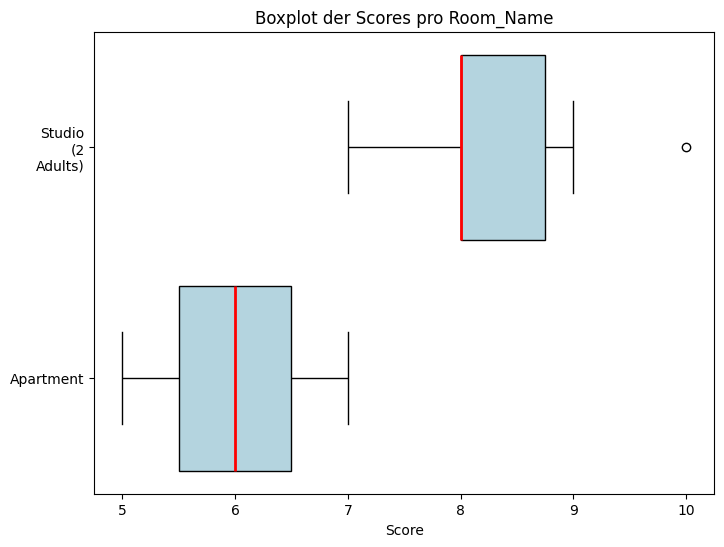

In [46]:
# create Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_46_gen['Room_Name']], data=df_sub_46_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

plt.title('Scores pro Room_Name')
plt.xlabel('Score')
plt.ylabel("")
plt.xticks(rotation=0)
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/score_room.png",bbox_inches='tight')

plt.show()


### Score x Travel Purpose

In [47]:
df_sub_46_gen.groupby("Travel_Purpose")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Travel_Purpose,,,,,,,,
business,5.0,7.6,1.81659,5.0,7.0,8.0,8.0,10.0
leisure,3.0,8.0,1.00000,7.0,7.5,8.0,8.5,9.0


In [48]:
df_sub_46_gen.groupby("Travel_Purpose")["Score"].value_counts()

Travel_Purpose  Score
business        8        2
                5        1
                7        1
                10       1
leisure         7        1
                8        1
                9        1
Name: count, dtype: int64

In [49]:
# create text
score_travel_class = df_sub_46_gen.groupby("Travel_Purpose")["Score"].describe().index.tolist()
s_t = df_sub_46_gen.groupby("Travel_Purpose")["Score"].describe()
s_t_text = ''
for i in score_travel_class:
    mean = s_t['mean'][i]
    if s_t['count'][i]>1:
        minimum=s_t['min'][i]
        maximum=s_t['max'][i]
        q1=s_t['25%'][i]
        q2=s_t['75%'][i]
        s_t_text = s_t_text + ' The class <' + i + '> is rated on average with ' + str(round(mean, 1)) + ' (Red), with the lowest rating of ' + str(minimum) + ' (Left bar) and the highest rating of ' + str(maximum) + ' (Right bar). 50% of the ratings (Blue) are between ' + str(round(q1, 1)) + ' and ' + str(round(q2, 1)) + '.'
    elif s_t['count'][i]==1:
        s_t_text = s_t_text + ' The class <' + i + '> has an average rating of ' + str(round(mean, 1)) + ' (Red). There was only one rating in this class.'
score_travel_text = 'Score-Travel Purpose Distribution:\nThe score distribution is shown for the travel purposes ' + ', '.join(score_travel_class) + '. ' + s_t_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Travel}}','Content']=score_travel_text

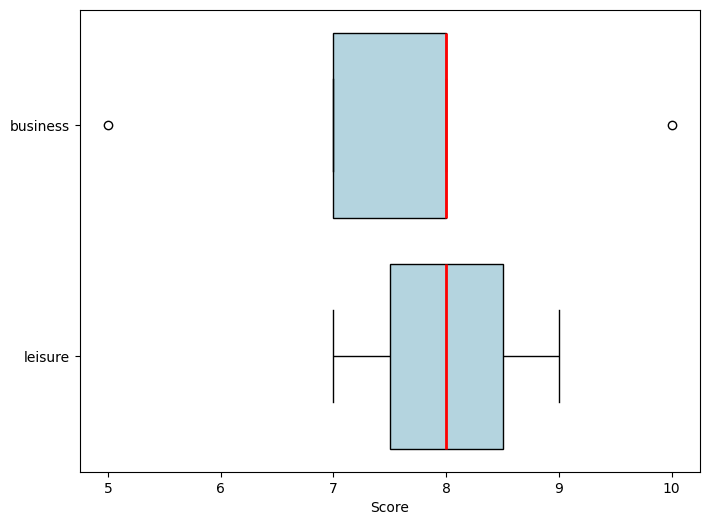

In [50]:
# create Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_46_gen['Travel_Purpose']], data=df_sub_46_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})


plt.xlabel('Score')
plt.ylabel("")
plt.xticks(rotation=0)
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/score_travel.png")
plt.show()


### Score x Customer Type

In [51]:
df_sub_46_gen.groupby("Customer_Type")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Customer_Type,,,,,,,,
Couple,2.0,8.00,1.414214,7.0,7.50,8.0,8.50,9.0
Group of friends,2.0,6.50,2.121320,5.0,5.75,6.5,7.25,8.0
Solo traveller,4.0,8.25,1.258306,7.0,7.75,8.0,8.50,10.0


In [52]:
df_sub_46_gen.groupby("Customer_Type")["Score"].value_counts()

Customer_Type     Score
Couple            7        1
                  9        1
Group of friends  5        1
                  8        1
Solo traveller    8        2
                  7        1
                  10       1
Name: count, dtype: int64

In [53]:
# create text for graph explanation
score_customer_class = df_sub_46_gen.groupby("Customer_Type")["Score"].describe().index.tolist()
s_c = df_sub_46_gen.groupby("Customer_Type")["Score"].describe()
s_c_text = ''
for i in score_customer_class:
    mean = s_c['mean'][i]
    if s_c['count'][i]>1:
        minimum=s_c['min'][i]
        maximum=s_c['max'][i]
        q1=s_c['25%'][i]
        q2=s_c['75%'][i]
        s_c_text = s_c_text + ' The class <' + i + '> is rated on average with ' + str(round(mean, 1)) + ' (Red), with the lowest rating of ' + str(minimum) + ' (Left bar) and the highest rating of ' + str(maximum) + ' (Right bar). 50% of the ratings (Blue) are between ' + str(round(q1, 1)) + ' and ' + str(round(q2, 1)) + '.'
    elif s_c['count'][i]==1:
        s_c_text = s_c_text + ' The class <' + i + '> has an average rating of ' + str(round(mean, 1)) + ' (Red). There was only one rating in this class.'
score_customer_text = 'Score-Customer Type Distribution:\nThe score distribution is shown for the customer types ' + ', '.join(score_customer_class) + '. ' + s_c_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Score_Customer}}','Content']=score_customer_text

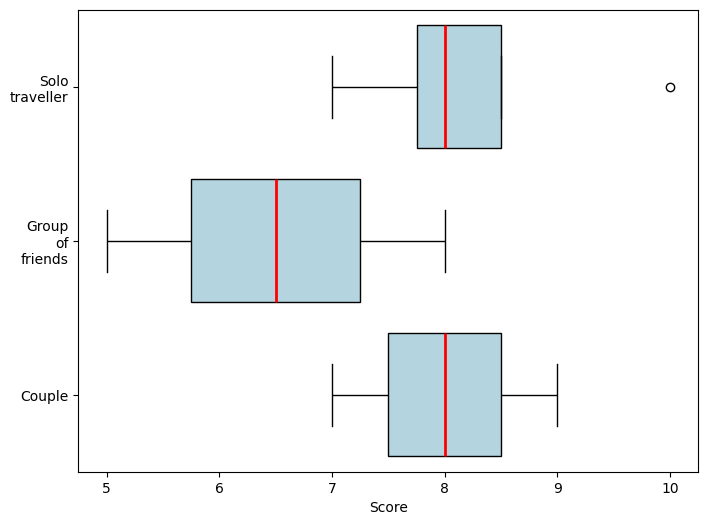

In [54]:
# create Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Score', y=[label.replace(' ','\n') for label in df_sub_46_gen['Customer_Type']], data=df_sub_46_gen, color="lightblue",
            linecolor="black",
           medianprops={"color": "r", "linewidth": 2})

plt.xlabel('Score')
plt.ylabel("")
plt.xticks(rotation=0)
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/score_customer.png")
plt.show()


## Comparison

### Score x Room Category

In [55]:
a=df_sub_46_gen.groupby("Room_Name")["Score"].describe().copy()
b=df_sub_45_gen.groupby("Room_Name")["Score"].describe().copy()

In [56]:
c=a-b# calculate the difference between the week 46 and 45

In [57]:
# create text for the graph
d_r_text =''
for i in c.index.tolist():
    if (round(c['mean'][i],2)>0) or (round(c['mean'][i],2)<0):
        d_r_text = d_r_text + 'The class <'+i+'> has on average '+str(round(c['mean'][i],2))+' Points'
        if round(c['mean'][i],2) > 0:
            d_r_text = d_r_text+' more than in the previous week. '
        elif round(c['mean'][i],2) <0:
            d_r_text = d_r_text+' less than in the previous week. '
    elif round(c['mean'][i],2)==0:
        d_r_text = d_r_text + 'The rating of class <'+i+'> did not changed to the previous week. '
    elif math.isnan(round(c['mean'][i],2)):
        d_r_text = d_r_text + 'For the class <'+i+'> there were no ratings given. '
        

In [58]:
diff_room = 'Score-Room Class Comparison:\nThe following changes occurred for the room categories rated this week compared to last week: ' + d_r_text

In [59]:
# save data in placeholder dataframe
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Room}}','Content']=diff_room

-4.0 red
-1.0 red
-4.0
-1.0


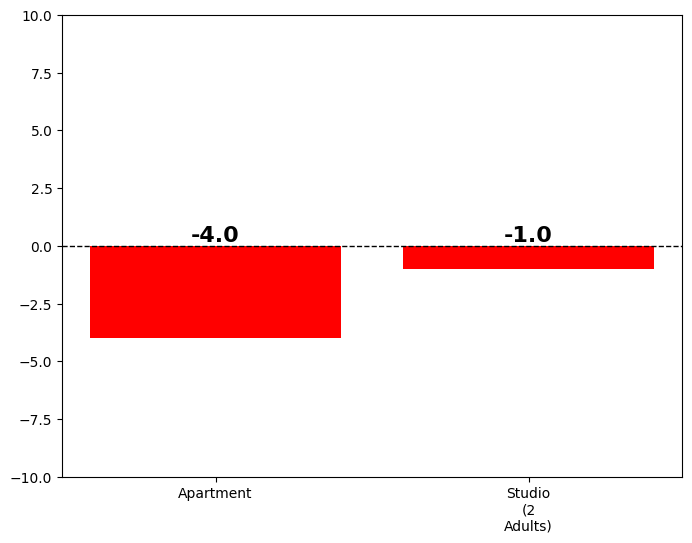

In [60]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in c['mean']:
    if diff < 0:
        colors.append('red')  # for negative values
        print(str(diff)+' red')
    elif diff > 0:
        colors.append('lightgreen')  # for positive values
        print(str(diff)+' green')
    elif math.isnan(diff):
        colors.append('black')
        
bars=plt.bar([label.replace(' ','\n') for label in c.index.tolist()], c["mean"], color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    print(yval)
    if not math.isnan(yval):
        if yval > 0:
            yval="+"+str(round(yval,2))
        elif yval<0:
            yval=str(round(yval,2))
        plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
                    yval,  # Display the rounded value
                    ha='center',  # Horizontal alignment of the text
                    va='bottom',  # Vertical alignment of the text
                    color='black' if yval != 0 else 'white',  # Text color based on the value
                    fontweight='bold',  # Make the text bold
                    fontsize=16)  # Set the font size to 12 pt

# Set y-axis limit
plt.ylim(-10,10) 
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/diff_room.png")
# Display the plot
plt.show()


### Score x Travel Purpose

In [61]:
d=df_sub_46_gen.groupby("Travel_Purpose")["Score"].describe().copy()
e=df_sub_45_gen.groupby("Travel_Purpose")["Score"].describe().copy()

In [62]:
f=d-e # calculate the difference
f["mean"]
f.index.tolist()

['business', 'leisure']

In [63]:
# create text explanation
d_t_text =''
for i in f.index.tolist():
    if (round(f['mean'][i],2)>0) or (round(f['mean'][i],2)<0):
        d_t_text = d_t_text + 'The class <'+i+'> has on average '+str(round(f['mean'][i],2))+' points'
        if round(f['mean'][i],2) > 0:
            d_t_text = d_t_text+' more than in the previous week. '
        elif round(f['mean'][i],2) <0:
            d_t_text = d_t_text+' less than in the previous week. '
    elif round(f['mean'][i],2)==0:
        d_t_text = d_t_text + 'The rating of the class <'+i+'> did not changed to the previous week. '
    elif math.isnan(round(f['mean'][i],2)):
        d_t_text = d_t_text + 'For the class <'+i+'> there were not any ratings given. '
diff_travel = 'Score-Travel Purpose Comparison:\nThe following changes occurred in the ratings based on the travel purpose compared to last week: ' + d_t_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Travel}}','Content']=diff_travel

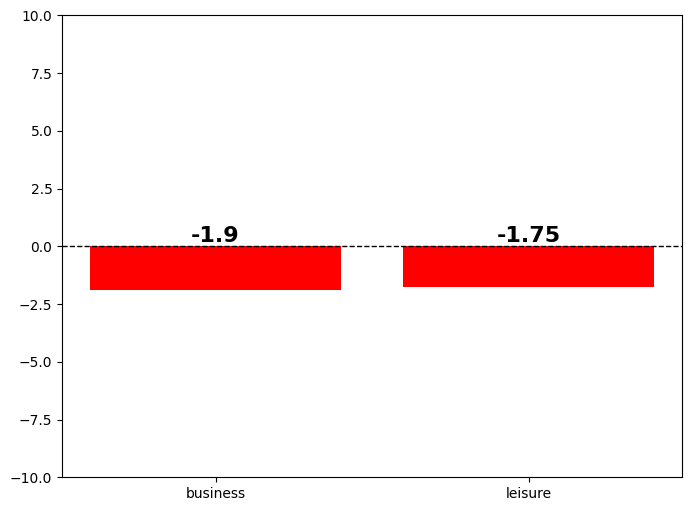

In [64]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in f['mean']:
    if diff < 0:
        colors.append('red')  # für negative Werte
    elif diff > 0.0:
        colors.append('lightgreen')  # für positive Werte
    elif math.isnan(diff):
        colors.append('black')
        
bars=plt.bar([label.replace(' ','\n') for label in f.index.tolist()], f["mean"], color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    if yval > 0:
        yval="+"+str(round(yval,2))
    else:
        yval=str(round(yval,2))
    plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
             yval,  # Display the rounded value
             ha='center',  # Horizontal alignment of the text
             va='bottom',  # Vertical alignment of the text
             color='black' if yval != 0 else 'white',  # Text color based on the value
             fontweight='bold',  # Make the text bold
             fontsize=16)  # Set the font size to 12 pt

# Set y axis
plt.ylim(-10,10) 
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/diff_travel.png")
# Display the plot
plt.show()

### Score x Customer Type

In [65]:
u=df_sub_46_gen.groupby("Customer_Type")["Score"].describe().copy()
p=df_sub_45_gen.groupby("Customer_Type")["Score"].describe().copy()

In [66]:
r=[]
t=(u-p)
r=t["mean"].dropna() # difference between weeks
r

Customer_Type
Couple             -1.000000
Group of friends   -3.166667
Solo traveller     -1.750000
Name: mean, dtype: float64

In [67]:
# create text
d_c_text =''
for i in t.index.tolist():
    if (round(t['mean'][i],2)>0) or (round(t['mean'][i],2)<0):
        d_c_text = d_c_text + 'The class <'+i+'> has on average  '+str(round(t['mean'][i],2))+' points'
        if round(t['mean'][i],2) > 0:
            d_c_text = d_c_text+' more than the previous week. '
        elif round(t['mean'][i],2) <0:
            d_c_text = d_c_text+' less than the previous week. '
    elif round(t['mean'][i],2)==0:
        d_c_text = d_c_text + 'The ratings of the class'+i+' did not changed. '
    elif math.isnan(round(t['mean'][i],2)):
        d_c_text = d_c_text + 'For the class'+i+' there were no ratings given. '
diff_customer = 'Score-Customer Type Comparison:\nThe ratings by customer type have changed as follows compared to last week: ' + d_c_text
df_placeholder.loc[df_placeholder['Placeholder']=='{{Diff_Customer}}','Content']=diff_customer

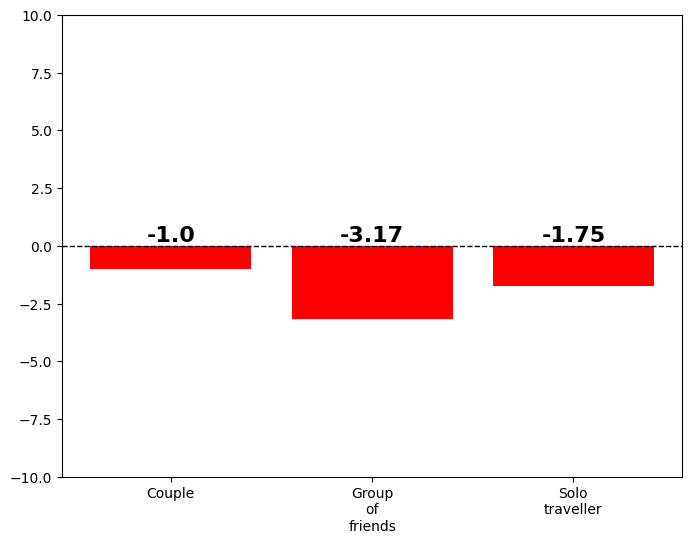

In [69]:
# Plotting the differences
plt.figure(figsize=(8, 6))
# Create a color array based on the value of the 'Difference' column
colors = []
for diff in r:
    if diff < 0:
        colors.append('red')  # für negative Werte
    elif diff > 0.0:
        colors.append('lightgreen')  # für positive Werte
    elif math.isnan(diff):
        colors.append('black')
bars=plt.bar([label.replace(' ','\n') for label in r.index.tolist()], r, color=colors)
# Adding horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height() # Get the height of the bar (the value)
    if yval > 0:
        yval="+"+str(round(yval,2))
    else:
        yval=str(round(yval,2))
    plt.text(bar.get_x() + bar.get_width() / 2, 0,  # Position the text
             yval,  # Display the rounded value
             ha='center',  # Horizontal alignment of the text
             va='bottom',  # Vertical alignment of the text
             color='black' if yval != 0 else 'white',  # Text color based on the value
             fontweight='bold',  # Make the text bold
             fontsize=16)  # Set the font size to 12 pt

plt.ylim(-10,10)
plt.savefig('../'+str(id)+"/Week_"+str(week)+"/diff_customer.png")
# Display the plot
plt.show()


## Sentiment Analysis

### Positive Stack

In [70]:
def stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind):
    # create DataFrame
    labels=["Pos_Sonst","Pos_Bad","Pos_Room","Pos_Amenities","Pos_Bar","Pos_Comfort","Pos_Food","Pos_Location","Pos_Wellness","Pos_Price","Pos_Service"]
    df = pd.DataFrame({"Pos_Sonst":sonst,
                       "Pos_Bad":bad,
                       "Pos_Room":room,
                       "Pos_Amenities":amen,
                       "Pos_Bar":bar,
                       "Pos_Comfort":comf,
                       "Pos_Food":food,
                       "Pos_Location":loc,
                       "Pos_Wellness":well,
                       "Pos_Price":price,
                       "Pos_Service":service},
                      index=[label.replace(' ','\n') for label in ind])
    # Normalize the data: scale each row to sum to 1
    df_normalized = df.div(df.sum(axis=1), axis=0)
    # create stacked bar chart for monthly temperatures
    df_normalized.plot(kind='bar', stacked=True)
    plt.legend(labels, loc="upper right", title="Kategorien")
    # labels for x & y axis
    #plt.xlabel('Months')
    plt.xticks(rotation=0)
    #plt.ylabel('Temp ranges in Degree Celsius')
    plt.savefig('../'+str(id)+"/Week_"+str(week)+"/pos_stack_room.png",bbox_inches='tight')
    # title of plot
    #plt.title('Monthly Temperatures in a year')

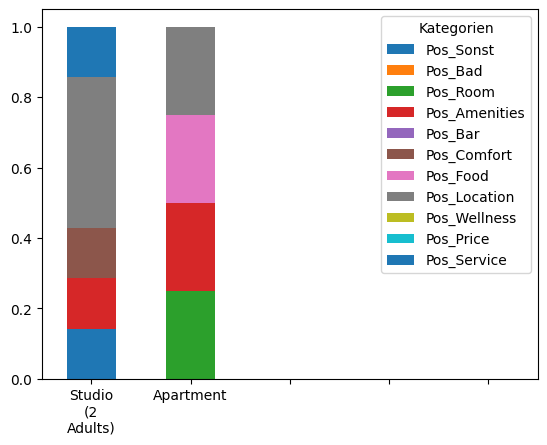

In [71]:
sonst=[]
bad=[]
room=[]
amen=[]
bar=[]
comf=[]
food=[]
loc=[]
well=[]
price=[]
service=[]
ind=[]
l=len(df_sub_46_gen["Room_Name"].value_counts().index.tolist())
for i in df_sub_46_gen["Room_Name"].value_counts().index.tolist():
    count2=df_sub_46_gen[(df_sub_46_gen["Room_Name"]==i)][["Pos_Sonst","Pos_Bad","Pos_Room","Pos_Amenities","Pos_Bar","Pos_Comfort","Pos_Food","Pos_Location","Pos_Wellness","Pos_Price","Pos_Service"]].copy()
    if count2["Pos_Sonst"].max()==1:
        sonst.append(count2["Pos_Sonst"].sum())
    else:
        sonst.append(0)
    if count2["Pos_Bad"].max()==1:
        bad.append(count2["Pos_Bad"].sum())
    else:
        bad.append(0)
    if count2["Pos_Room"].max()==1:
        room.append(count2["Pos_Room"].sum())
    else:
        room.append(0)
    if count2["Pos_Amenities"].max()==1:
        amen.append(count2["Pos_Amenities"].sum())
    else:
        amen.append(0)
    if count2["Pos_Bar"].max()==1:
        bar.append(count2["Pos_Bar"].sum())
    else:
        bar.append(0)
    if count2["Pos_Comfort"].max()==1:
        comf.append(count2["Pos_Comfort"].sum())
    else:
        comf.append(0)
    if count2["Pos_Food"].max()==1:
        food.append(count2["Pos_Food"].sum())
    else:
        food.append(0)
    if count2["Pos_Location"].max()==1:
        loc.append(count2["Pos_Location"].sum())
    else:
        loc.append(0)
    if count2["Pos_Wellness"].max()==1:
        well.append(count2["Pos_Wellness"].sum())
    else:
        well.append(0)
    if count2["Pos_Price"].max()==1:
        price.append(count2["Pos_Price"].sum())
    else:
        price.append(0)
    if count2["Pos_Service"].max()==1:
        service.append(count2["Pos_Service"].sum())
    else:
        service.append(0)
    ind.append(i)
sonst.extend([float('nan'),float('nan'),float('nan')])
bad.extend([float('nan'),float('nan'),float('nan')])
room.extend([float('nan'),float('nan'),float('nan')])
amen.extend([float('nan'),float('nan'),float('nan')])
bar.extend([float('nan'),float('nan'),float('nan')])
comf.extend([float('nan'),float('nan'),float('nan')])
food.extend([float('nan'),float('nan'),float('nan')])
loc.extend([float('nan'),float('nan'),float('nan')])
well.extend([float('nan'),float('nan'),float('nan')])
price.extend([float('nan'),float('nan'),float('nan')])
service.extend([float('nan'),float('nan'),float('nan')])
ind.extend(['','',''])
stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind)

### Negative Stack

In [74]:
def stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind):
    # create DataFrame
    labels=["Neg_Sonst","Neg_Bad","Neg_Room","Neg_Amenities","Neg_Bar","Neg_Comfort","Neg_Food","Neg_Location","Neg_Wellness","Neg_Price","Neg_Service"]
    df = pd.DataFrame({"Neg_Sonst":sonst,
                       "Neg_Bad":bad,
                       "Neg_Room":room,
                       "Neg_Amenities":amen,
                       "Neg_Bar":bar,
                       "Neg_Comfort":comf,
                       "Neg_Food":food,
                       "Neg_Location":loc,
                       "Neg_Wellness":well,
                       "Neg_Price":price,
                       "Neg_Service":service},
                      index=[label.replace(' ','\n') for label in ind])
    # Normalize the data: scale each row to sum to 1
    df_normalized = df.div(df.sum(axis=1), axis=0)
    # create stacked bar chart for monthly temperatures
    df_normalized.plot(kind='bar', stacked=True)
    plt.legend(labels, loc="upper right", title="Kategorien")
    #bbox_to_anchor=(1, 0.5)
    # labels for x & y axis
    #plt.xlabel('Months')
    plt.xticks(rotation=0)
    #plt.ylabel('Temp ranges in Degree Celsius')
    plt.savefig('../'+str(id)+"/Week_"+str(week)+"/neg_stack_room.png",bbox_inches='tight')
    # title of plot
    #plt.title('Monthly Temperatures in a year')

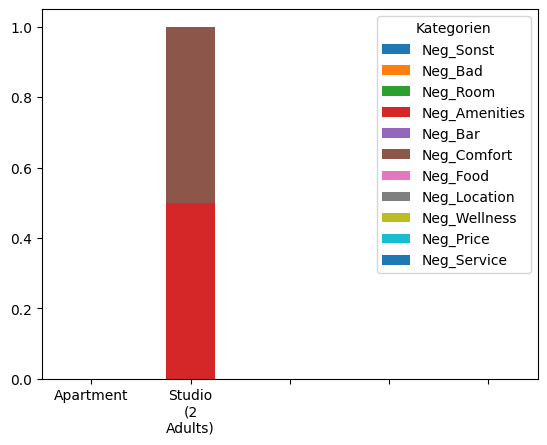

In [75]:
sonst=[]
bad=[]
room=[]
amen=[]
bar=[]
comf=[]
food=[]
loc=[]
well=[]
price=[]
service=[]
ind=[]
l=len(df_sub_45_gen["Room_Name"].value_counts().index.tolist())
for i in df_sub_45_gen["Room_Name"].value_counts().index.tolist():
    count2=df_sub_45_gen[(df_sub_45_gen["Room_Name"]==i)][["Neg_Sonst","Neg_Bad","Neg_Room","Neg_Amenities","Neg_Bar","Neg_Comfort","Neg_Food","Neg_Location","Neg_Wellness","Neg_Price","Neg_Service"]].copy()
    if count2["Neg_Sonst"].max()==1:
        sonst.append(count2["Neg_Sonst"].sum())
    else:
        sonst.append(0)
    if count2["Neg_Bad"].max()==1:
        bad.append(count2["Neg_Bad"].sum())
    else:
        bad.append(0)
    if count2["Neg_Room"].max()==1:
        room.append(count2["Neg_Room"].sum())
    else:
        room.append(0)
    if count2["Neg_Amenities"].max()==1:
        amen.append(count2["Neg_Amenities"].sum())
    else:
        amen.append(0)
    if count2["Neg_Bar"].max()==1:
        bar.append(count2["Neg_Bar"].sum())
    else:
        bar.append(0)
    if count2["Neg_Comfort"].max()==1:
        comf.append(count2["Neg_Comfort"].sum())
    else:
        comf.append(0)
    if count2["Neg_Food"].max()==1:
        food.append(count2["Neg_Food"].sum())
    else:
        food.append(0)
    if count2["Neg_Location"].max()==1:
        loc.append(count2["Neg_Location"].sum())
    else:
        loc.append(0)
    if count2["Neg_Wellness"].max()==1:
        well.append(count2["Neg_Wellness"].sum())
    else:
        well.append(0)
    if count2["Neg_Price"].max()==1:
        price.append(count2["Neg_Price"].sum())
    else:
        price.append(0)
    if count2["Neg_Service"].max()==1:
        service.append(count2["Neg_Service"].sum())
    else:
        service.append(0)
    ind.append(i)
sonst.extend([float('nan'),float('nan'),float('nan')])
bad.extend([float('nan'),float('nan'),float('nan')])
room.extend([float('nan'),float('nan'),float('nan')])
amen.extend([float('nan'),float('nan'),float('nan')])
bar.extend([float('nan'),float('nan'),float('nan')])
comf.extend([float('nan'),float('nan'),float('nan')])
food.extend([float('nan'),float('nan'),float('nan')])
loc.extend([float('nan'),float('nan'),float('nan')])
well.extend([float('nan'),float('nan'),float('nan')])
price.extend([float('nan'),float('nan'),float('nan')])
service.extend([float('nan'),float('nan'),float('nan')])
ind.extend(['','',''])
stack(sonst,bad,room,amen,bar,comf,food,loc,well,price,service,ind)

# Saving Placeholder DataFrame in Excel File

In [76]:
# Save new Dataframe
placeholder_path='../'+str(id)+"/Week_"+str(week)+"/placeholder_week_"+str(week)+"_id_"+str(id)
df_placeholder.to_excel(placeholder_path+".xlsx")